# Extract the Mesh from Nerf
### Input -> Nerf Model -> Out put
### input: (Batch size,3,3) which goes to an embedder, then to NN. 
### output: (B,4), (RGB,sigma), sigma=volume density.

In [1]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import imageio
import pprint

import matplotlib.pyplot as plt

import run_nerf
import run_nerf_helpers
import configargparse

import open3d as o3d

2022-06-02 17:21:43.426531: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-02 17:21:43.933569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4259 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
basedir = '/home/liteandfog/Desktop/raspi-colmap/data/output/nerf'
datadir='/home/liteandfog/Desktop/raspi-colmap/data/output'
expname = 'test8'
model_name='model_160000.npy'

In [3]:

config = os.path.join(basedir, expname, 'args.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()
ft_str = '' 
ft_str = ' --ft_path {}'.format(os.path.join(basedir, expname, model_name))

config_str ='--config {}'.format(config)
args = parser.parse_args(config_str + ft_str)
args.datadir=datadir # correct the datadir to the location of the .npy file.


Args:
N_importance = 128
N_rand = 4096
N_samples = 64
basedir = /home/liteandfog/raspi-colmap/data/output/nerf
chunk = 32768
config = None
datadir = /home/liteandfog/raspi-colmap/data/output
expname = test8
factor = 8
ft_path = None
i_embed = 0
i_img = 500
i_print = 100
i_testset = 50000
i_video = 50000
i_weights = 10000
lindisp = True
llffhold = 8
lrate = 0.0005
lrate_decay = 250
multires = 10
multires_views = 4
netchunk = 65536
netdepth = 8
netdepth_fine = 8
netwidth = 256
netwidth_fine = 256
no_batching = False
no_ndc = True
no_reload = False
perturb = 1.0
precrop_frac = 0.5
precrop_iters = 0
raw_noise_std = 0.0
render_factor = 0
render_only = False
render_test = False
spherify = False
testskip = 8
use_viewdirs = True
white_bkgd = False



In [4]:
args

Namespace(N_importance=128, N_rand=4096, N_samples=64, basedir='/home/liteandfog/raspi-colmap/data/output/nerf', chunk=32768, config='/home/liteandfog/Desktop/raspi-colmap/data/output/nerf/test8/args.txt', datadir='/home/liteandfog/Desktop/raspi-colmap/data/output', expname='test8', factor=8, ft_path='/home/liteandfog/Desktop/raspi-colmap/data/output/nerf/test8/model_160000.npy', i_embed=0, i_img=500, i_print=100, i_testset=50000, i_video=50000, i_weights=10000, lindisp=True, llffhold=8, lrate=0.0005, lrate_decay=250, multires=10, multires_views=4, netchunk=65536, netdepth=8, netdepth_fine=8, netwidth=256, netwidth_fine=256, no_batching=False, no_ndc=True, no_reload=False, perturb=1.0, precrop_frac=0.5, precrop_iters=0, raw_noise_std=0.0, render_factor=0, render_only=False, render_test=False, spherify=False, testskip=8, use_viewdirs=True, white_bkgd=False)

# Create Nerf

In [5]:
# Create nerf model
render_kwargs_train, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(
        args)

2022-06-02 17:21:46.244339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4259 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6


MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
Not ndc!
Found ckpts ['/home/liteandfog/Desktop/raspi-colmap/data/output/nerf/test8/model_160000.npy']
Reloading from /home/liteandfog/Desktop/raspi-colmap/data/output/nerf/test8/model_160000.npy
Resetting step to 160001
Reloading fine from /home/liteandfog/Desktop/raspi-colmap/data/output/nerf/test8/model_fine_160000.npy


In [6]:
render_kwargs_train

{'network_query_fn': <function run_nerf.create_nerf.<locals>.network_query_fn(inputs, viewdirs, network_fn)>,
 'perturb': 1.0,
 'N_importance': 128,
 'network_fine': <keras.engine.functional.Functional at 0x7ff0143bfee0>,
 'N_samples': 64,
 'network_fn': <keras.engine.functional.Functional at 0x7ff034063d60>,
 'use_viewdirs': True,
 'white_bkgd': False,
 'raw_noise_std': 0.0,
 'ndc': False,
 'lindisp': True}

In [7]:
render_kwargs_test

{'network_query_fn': <function run_nerf.create_nerf.<locals>.network_query_fn(inputs, viewdirs, network_fn)>,
 'perturb': False,
 'N_importance': 128,
 'network_fine': <keras.engine.functional.Functional at 0x7ff0143bfee0>,
 'N_samples': 64,
 'network_fn': <keras.engine.functional.Functional at 0x7ff034063d60>,
 'use_viewdirs': True,
 'white_bkgd': False,
 'raw_noise_std': 0.0,
 'ndc': False,
 'lindisp': True}

In [8]:
len(grad_vars)

48

In [9]:
models["model_fine"].summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
tf.split_1 (TFOpLambda)         [(None, 63), (None,  0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 256)          16384       tf.split_1[0][0]                 
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 256)          65792       dense_12[0][0]                   
____________________________________________________________________________________________

# Data pipeline

In [10]:
def colmap_compatible(poses_org):
    "input shape: Nx4x3"
    poses_org[:, :3, :3] = np.matmul(poses_org[:, :3, :3], np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]]))
    return poses_org


#our Nerf data pipeline.
data = np.load(os.path.join(args.datadir, "data.npz"))
# data = np.load("/home/liteandfog/Desktop/raspi-colmap/data/output/data.npz")
images, poses, focal, bds = (data["images"], data["poses"], data["focal"], data["bds"])
# Cast intrinsics to right types
_, H, W, _ = images.shape
hwf = [int(H), int(W), focal]

print('Loaded llff', images.shape, hwf)


poses = poses[:, :3, :4] #NxHxW

# colmap's coordinates convention
poses = colmap_compatible(poses)

poses = poses.astype('float32')
images = images.astype('float32')
focal = focal.astype('float32')
bds = bds.astype('float32')


# train/test splitting
print('Auto LLFF holdout,', args.llffhold)
i_test = np.arange(images.shape[0])[::args.llffhold]
i_val = i_test
i_train = np.array([i for i in np.arange(int(images.shape[0])) if (i not in i_test and i not in i_val)])

# Spiral path for rendering
render_poses = np.array(poses[i_test])

# get boundaries

near,far=bds[:,0].min(),bds[:,1].max()

print("Scene boundaries:",near,far)

Loaded llff (180, 86, 130, 3) [86, 130, array(154.85165485)]
Auto LLFF holdout, 8
Scene boundaries: 0.578642 10.909596


In [11]:
t_world=poses[:,:,-2]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(t_world)
o3d.visualization.draw_geometries([pcd], point_show_normal=False)

In [12]:
t_world.shape

(180, 3)

# get rays

In [13]:
# Ray helpers
def get_rays(H, W, focal, c2w):
    """Get ray origins, directions from a pinhole camera."""
    
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32),
                       tf.range(H, dtype=tf.float32), 
                       indexing='xy')
    
    
    # Normalize the x axis coordinates.
    transformed_i = (i - W * 0.5) / focal
    # Normalize the y axis coordinates.
    transformed_j = (j - H * 0.5) / focal
    # Create the direction unit vectors.
    dirs = tf.stack([transformed_i, transformed_j, -tf.ones_like(i)], -1)
    # Get the camera matrix.
    camera_matrix = c2w[:3, :3]
    hwf = c2w[:3, -1]
    # Get origins and directions for the rays.
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * camera_matrix, -1)
    rays_o = tf.broadcast_to(hwf, tf.shape(rays_d))
    return rays_o, rays_d

def get_rays_np(H, W, focal, c2w):
    """Get ray origins, directions from a pinhole camera."""
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    rays_o = np.broadcast_to(c2w[:3, -1], np.shape(rays_d))
    return rays_o, rays_d


def render_flat_rays(ray_origins, ray_directions, near=near, far=far, num_samples=args.N_samples):
    """Renders the rays and flattens it.
    
    TODO: return rays along rays directions
    
    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    t_vals = tf.linspace(near, far, num_samples)
    # Equation: r(t) = o + td -> Building the "r" here.
    rays_dir = ray_directions[..., None, :] * t_vals[..., None]
    rays = ray_origins[..., None, :] + rays_dir
    # flattens the ray
    rays_flat = tf.reshape(rays, [-1, 3])
    
    return (rays_flat, t_vals, rays, rays_dir)

In [14]:
(ray_origins, ray_directions) = get_rays(H, W, focal, poses[0])
    
(rays_flat, t_vals, rays_pos,rays_dir) = render_flat_rays(
        ray_origins = ray_origins,
        ray_directions = ray_directions,
        near = near,
        far = far,
        num_samples = args.N_samples)

In [15]:
rays_d= tf.reshape(ray_directions[..., None, :] * t_vals[..., None], [-1,3])
sum_of_rows = rays_d.numpy().sum(axis=1)
normalized_array = rays_d / sum_of_rows[:, np.newaxis]

In [16]:
#Extracting rays (o and d) for all poses.

rays = [get_rays_np(H, W, focal, p) for p in poses[:, :3, :4]] #list of length num_cameras with elements tuples (r_o,r_d) of shape (H,W,3) each.

print("num_cameras:", len(rays))
print("H,W,Channels: ", rays[0][0].shape)

num_cameras: 180
H,W,Channels:  (86, 130, 3)


# Render 3D Scene

In [17]:
def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


In [18]:
pose_spherical(0., .0, 4.0)

2022-06-02 17:21:57.698049: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 1.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0., -1., -4.],
       [ 0.,  0.,  0.,  1.]], dtype=float32)>

# load nerf model

MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
Not ndc!
Found ckpts ['/home/liteandfog/Desktop/raspi-colmap/data/output/nerf/test8/model_160000.npy']
Reloading from /home/liteandfog/Desktop/raspi-colmap/data/output/nerf/test8/model_160000.npy
Resetting step to 160001
Reloading fine from /home/liteandfog/Desktop/raspi-colmap/data/output/nerf/test8/model_fine_160000.npy
Render kwargs:
{'N_importance': 128,
 'N_samples': 64,
 'far': <tf.Tensor: shape=(), dtype=float32, numpy=10.909596>,
 'lindisp': True,
 'ndc': False,
 'near': <tf.Tensor: shape=(), dtype=float32, numpy=0.578642>,
 'network_fine': <keras.engine.functional.Functional object at 0x7fef98b1e9a0>,
 'network_fn': <keras.engine.functional.Functional object at 0x7fef98b69ca0>,
 'network_query_fn': <function create_nerf.<locals>.network_query_fn at 0x7fef98b4fdc0>,
 'perturb': False,
 'raw_noise_std': 0.0,
 'use_viewdirs': 

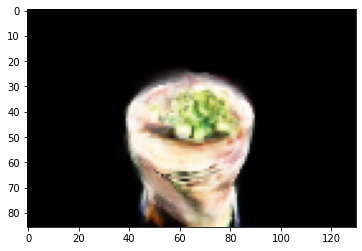

In [19]:
# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(near, tf.float32),
    'far' : tf.cast(far, tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

net_fn = render_kwargs_test['network_query_fn']
print(net_fn)

# Render an overhead view to check model was loaded correctly
c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
c2w=np.squeeze(colmap_compatible(c2w[np.newaxis,:]))
c2w[2,-1] = -4.
c2w=pose_spherical(0., -30, 5.0)
test = run_nerf.render(H, W, focal, c2w=c2w, **render_kwargs_test)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

### Query network on dense 3d grid of points

(513, 513, 513, 3)
(513, 513, 513, 4)


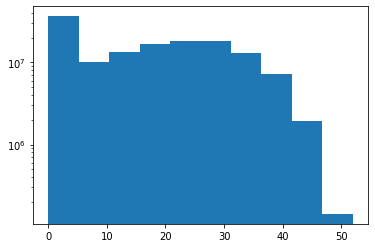

In [20]:
N = 512
t = np.linspace(-0.5, 0.5, N+1)

query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
print(query_pts.shape)
sh = query_pts.shape
flat = query_pts.reshape([-1,3])


def batchify(fn, chunk):
    if chunk is None:
        return fn
    def ret(inputs):
        return tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret
    
    
fn = lambda i0, i1 : net_fn(flat[i0:i1,None,:], viewdirs=np.zeros_like(flat[i0:i1]), network_fn=render_kwargs_test['network_fine'])
chunk = 1024*64
raw = np.concatenate([fn(i, i+chunk).numpy() for i in range(0, flat.shape[0], chunk)], 0)
raw = np.reshape(raw, list(sh[:-1]) + [-1])
sigma = np.maximum(raw[...,-1], 0.)

print(raw.shape)
plt.hist(np.maximum(0,sigma.ravel()), log=True)
plt.show()

# Get Rays directly.

# 1. Plot Scene coverage for a sanity check

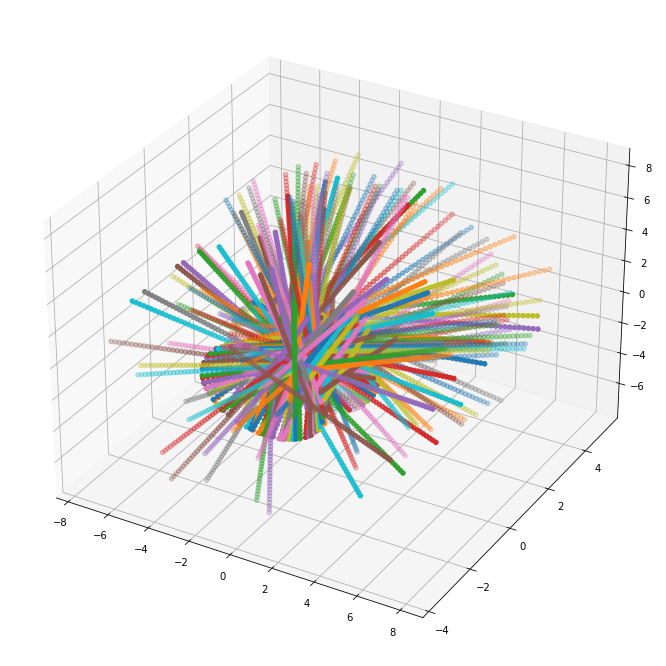

In [21]:
cameras=[x for x in range(len(poses))]


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for cam in cameras:
    (ray_origins, ray_directions) = get_rays(H, W, focal, poses[cam])
    
    (rays_flat, t_vals, rays_pos,_) = render_flat_rays(
        ray_origins = ray_origins,
        ray_directions = ray_directions,
        near = near,
        far = far,
        num_samples = args.N_samples)
 
    def random_sample(h,w,k):
        import random
        tup = tuple((y,x) for x in range(w) for y in range(h))
        return random.sample(tup,k)
    
    coor_rand = random_sample(H,W,1)
    for coor in coor_rand:
    
        i,j = coor
        ray = rays_pos[i][i].numpy()
        ray_x = list(ray[:,0])
        ray_y = list(ray[:,1])
        ray_z = list(ray[:,2])
    
        ax.scatter(ray_x, ray_y, ray_z)
    
    
plt.savefig(f'{expname}_RaysCoverOfScene.png')
plt.show()   

In [22]:
def extract_mesh(**keyargs):
    import random
    #init
    cameras = random.sample([x for x in range(len(poses))],keyargs['NUMBER_OF_CAMERAS'])
    pcd_points = np.empty(shape=(3))
    pcd_colors = np.empty(shape= (3))
    
    for cam in cameras:
        camera_pos=poses[cam] # fetch camera parameters
        
        # rays extraction
        (ray_origins, ray_directions) = get_rays(H, W, focal, camera_pos) #returns origins and directions for each camera  
    
        (rays_flat, t_vals, rays_pos,rays_d) = render_flat_rays(
            ray_origins = ray_origins,
            ray_directions = ray_directions,
            near = near,
            far = far,
            num_samples = args.N_samples) # returns flat rays, sample param t, ray (HxWxN_samp,3),ray_dirs
    
        #set Batch size == 1
        rays_flat,t_vals = rays_flat[None,...], t_vals[None,...]
        
        ## model prediction:
        predictions = net_fn(rays_flat[:,None,:], viewdirs=tf.reshape(rays_dir,[1,-1,3]), network_fn=render_kwargs_test['network_fine'])
        predictions = tf.reshape(predictions, shape=(1, H, W, args.N_samples, 4))
        ####
        
        # Slice the predictions into rgb and sigma.
        rgb = np.squeeze(tf.sigmoid(predictions[..., :-1]))
        sigma = np.squeeze(tf.nn.relu(predictions[..., -1]))
        rays_pos=rays_pos.numpy()
        rays_pos_flat = tf.reshape(rays_pos, [-1, 3]).numpy()
        rgb_flat = tf.reshape(rgb, [-1, 3]).numpy()
        sigma_flat= np.squeeze(tf.reshape(sigma, [-1, 1]).numpy())
        
        #filtering
        mesh_points = rays_pos_flat[np.where((sigma_flat > keyargs["EPS"]) & (rgb_flat.sum(axis=1) > keyargs["EPS_RGB_MIN"]) & (rgb_flat.sum(axis=1) < keyargs["EPS_RGB_MAX"])   ) ] # filter out by total RGB value
        mesh_colors = rgb_flat[np.where((sigma_flat > keyargs["EPS"]) & (rgb_flat.sum(axis=1) > keyargs["EPS_RGB_MIN"]) & (rgb_flat.sum(axis=1) < keyargs["EPS_RGB_MAX"])   )] # filter out by total RGB value
        
        #vertical stacking
        pcd_points = np.vstack((pcd_points,mesh_points))
        pcd_colors = np.vstack((pcd_colors,mesh_colors))
    
    return pcd_points, pcd_colors

def plot_pcd(pcd_points,pcd_colors):
    print(pcd_points.shape)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcd_points)
    pcd.colors = o3d.utility.Vector3dVector(pcd_colors)
    #o3d.io.write_point_cloud(f"./{expname}_mesh.ply", pcd, write_ascii=True)
    o3d.visualization.draw_geometries([pcd], point_show_normal=False)

In [23]:
kwargs_extract_mesh = {
        'EPS': 10.,
        'EPS_RGB_MIN': 0.1,
        'EPS_RGB_MAX': 5.8,
        'NUMBER_OF_CAMERAS': 10}


pcd_points, pcd_colors=extract_mesh(**kwargs_extract_mesh)
plot_pcd(pcd_points,pcd_colors)

(107260, 3)
